In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia

In [ ]:
# Input Variables
# Example: NGC6397

name = "NGC6397"

# Galactic coordinates of the globular cluster
# Example: Aladin lite can search the cluster by target identifier: https://aladin.cds.unistra.fr/AladinLite/
ra_new = 265.175375
dec_new = -53.674333

# Proper motion coordinates of the cluster
# Example database: https://simbad.u-strasbg.fr/simbad/sim-basicIdent=m33&submit=SIMBAD+search
centerx, centery = -17.600	, 3.300	

# Cutoff radius in the proper motion space 
# rad is the distance from the center of the cluster, rad2 is the radius of the circle within which we keep the members
rad, rad2 = 0, 1.5

## Load tables and download the data from the Gaia archive

The query retrieves Gaia source data within a 5 arcminute radius of the specified coordinates, filtering for sources with a photometric 
magnitude in the $G_{BP}$ band less than 20.3. It selects the source ID, coordinates (RA, Dec), proper motions (pmra, pmdec), mean magnitudes in the $G$, $G_{BP}$, and $G_{RP}$ bands, astrometric parameters solved status, and the distance from the specified coordinates. The results are saved to a file for further processing. This code is designed to query the Gaia archive for data related to a specific globular cluster, filtering based on proper motion and photometric properties. The results are then processed to clean the data for further analysis.

In [ ]:
tables = Gaia.load_tables(only_names=True)

job = Gaia.launch_job_async(
    f"SELECT gaia_source.source_id, gaia_source.ra, gaia_source.dec, "
    f"gaia_source.pmra, gaia_source.pmdec, gaia_source.phot_g_mean_mag, "
    f"gaia_source.bp_rp, gaia_source.astrometric_params_solved, "
    f"gaia_source.phot_g_mean_flux, gaia_source.phot_bp_mean_flux, "
    f"gaia_source.phot_rp_mean_flux, "
    f"DISTANCE({ra_new}, {dec_new}, ra, dec) "
    f"FROM gaiadr3.gaia_source "
    f"WHERE DISTANCE({ra_new}, {dec_new}, ra, dec) < 5./60. "
    f"AND phot_bp_mean_mag < 20.3",
    dump_to_file=True
)

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]


The results of the Gaia query are stored in a VOTable format, which can be processed further read in as pandas dataframe (df). 
The file contains the source ID, coordinates (RA, Dec), proper motions (pmra, pmdec), mean magnitudes in the $G$, $G_{BP}$, and $G_{RP}$ bands, astrometric 
parameters solved status, and the distance from the specified coordinates. In this section, we will filter the data based on proper motion. 
We will remove sources outside the specified proper motion range, which is defined by the center coordinates (centerx, centery) and the 
cutoff radius (rad, rad2). The data will be cleaned to ensure that only relevant sources are retained for further analysis. 

In [ ]:

df = job.get_results().to_pandas()

# Filter out rows where 'astrometric_params_solved' is not 3
df = df[df['astrometric_params_solved'] != 3]

# Compute squared distance for filtering
distance_sq = (df.pmdec - centerx) ** 2 + (df.pmra - centery) ** 2
df = df[(distance_sq > rad**2) & (distance_sq < rad2**2)]

# Filter out rows with NaN in 'bp_rp'
df = df[df['bp_rp'].notna()]

## Corrected BP and RP flux excess (Riello, M. et al 2021)

Using the color excess parameter (C∗) defined by M. Riello et al. (2021), we applied a 1 sigma cut in C∗
(as a function of G) to exclude stars with potentially problematic photometry.

In [ ]:
def c(i_bp, i_rp, i_g):
    return (i_bp + i_rp) / i_g

# Constants
c0 = 0.0059898 
c1 = 8.817481e-11  
c3 = 7.618399

def sigma_c(g_m):
    return c0 + c1 * g_m**c3

def f(g_bprp):
    return (
        1.154360 + 0.033772 * g_bprp + 0.032277 * g_bprp**2
        if g_bprp < 0.5
        else 1.162004 + 0.011464 * g_bprp + 0.049255 * g_bprp**2
    )

df['c'] = df.apply(lambda row: c(row['phot_bp_mean_flux'], row['phot_rp_mean_flux'], row['phot_g_mean_flux']), axis=1)
df['sigma_c'] = df['phot_g_mean_mag'].apply(sigma_c)
df['c_star'] = df['bp_rp'].apply(f)
df['c_diff'] = df['c'] - df['c_star']

# Apply filtering: Keep rows where c_diff is within ±sigma_c 
df = df[(df['c_diff'] >= -df['sigma_c']) & (df['c_diff'] <= df['sigma_c'])]

## Export the data 
np.savetxt(f"{name}.txt", df[['bp_rp','phot_g_mean_mag']].to_numpy(), fmt="%.6f", delimiter=" ")

## Display the result Color Magnitude Diagram of the Cluster - optional

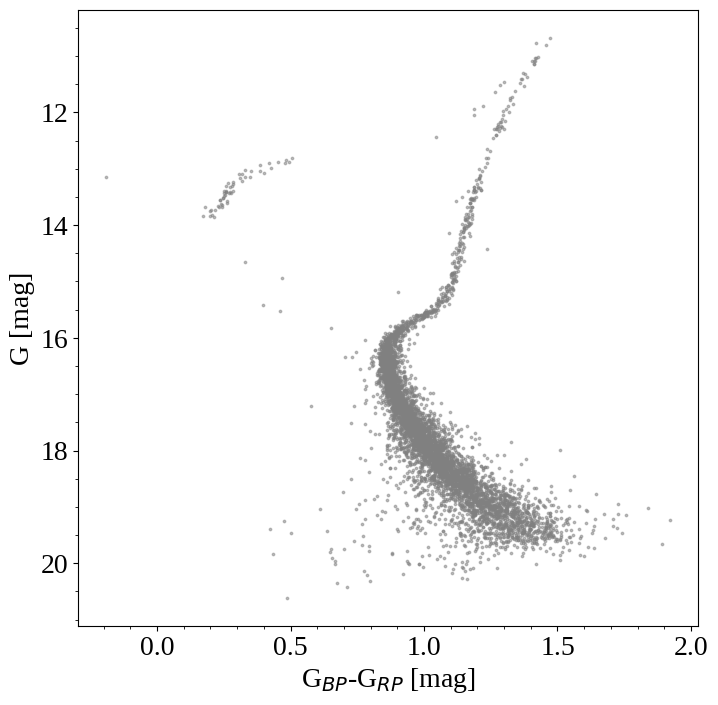

In [ ]:
# Set the point size and transparency
s=3
alpha=0.5

# Set the font size and family for the plot
plt.rcParams.update({'font.size': 20})
# plt.rcParams["font.family"] = "Liberation Serif" #specital font family, can be changed to any other font family installed on the system

##The plot

fig = plt.figure(figsize=(8,8))
plt.gca().invert_yaxis()

plt.minorticks_on()
plt.scatter(df['bp_rp'],df['phot_g_mean_mag'], s=s, alpha=alpha, c='grey')

plt.xlabel('G$_{BP}$-G$_{RP}$ [mag]')
plt.ylabel('G [mag]')

# Set additional parameters for the plot
#plt.xlim(0.7, 1.5)
#plt.ylim(20, 10)

#plt.savefig(f"{name}.png")
plt.show()

## Figure of the cut by the $C^*$ factor described in Riello, M. et al 2021

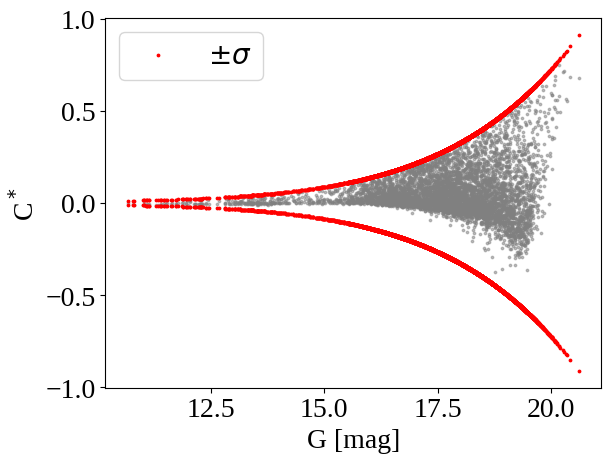

In [10]:
plt.scatter(df['phot_g_mean_mag'], df['c'] - df['c_star'], s=s, alpha=alpha, color="grey")
plt.scatter(df['phot_g_mean_mag'], df['sigma_c'], s=s, c="red", label=r"$\pm\sigma$")
plt.scatter(df['phot_g_mean_mag'], -df['sigma_c'], s=s, c="red")
plt.xlabel('G [mag]')
plt.ylabel('C$^*$')
plt.legend()
plt.show()